# Trabalho 2 - Conway’s Game of Life

Paulo Jorge Fernandes Freitas - A100053 & Pedro Manuel Pereira dos Santos - A100110

2. O Conway’s Game of Life é um exemplo conhecido de um autómato celular . Aqui vamos modificar as regras do autómato de forma a usar um espaço de estados finito
    1. O espaço de estados é finito definido por uma grelha de células booleanas (morta=0/viva=1) de dimensão $\,N\times N\,$ (com $N>3$) identificadas por índices $\,(i,j)\in \{1..N\}$.  Estas $\;N^2\;$ células são aqui referidas como “normais”. 
    2. No estado inicial todas as células normais estão mortas excepto  um quadrado $\,3\times 3\,$, designado por “centro”, aleatoriamente posicionado formado apenas por células vivas.
    3. Adicionalmente existem $\,2\,N+1\,$ “células da borda” que correspondem a um dos índices, $i$ ou $j$, ser zero. As células da borda têm valores constantes que, no estado inicial, são gerados aleatoriamente com uma probabilidade $\,\rho\,$ de estarem vivas.
    4. As células normais o autómato modificam o estado de acordo com a regra “B3/S23”: i.e. a célula nasce (passa de $0$ a $1$) se tem exatamente 3 vizinhos vivos e sobrevive (mantém-se viva) se o número de vizinhos vivos é 2 ou 3, caso contrário morre ou continua morta. 
    
**Nota:** A célula $\;(i_0,j_0)\;$ e $\,(i_1,j_1)\,$ são vizinhas sse $\;(i_0-i_1=\pm 1) \,\lor\, (j_0-j_1 = \pm 1)$

## Análise do problema

A. Construir uma máquina de estados finita que represente este autómato;  
B. Verificar se se conseguem provar as seguintes propriedades:
1. Todos os estados acessíveis contém pelo menos uma célula.
2. Toda a célula normal está viva pelo menos uma vez em algum estado acessível.

## Autómato em pySMT

Começamos por importar a biblioteca:
1. pysmt.shortcuts e pysmt.typing para as operações em pySMT
2. random para gerar aleatoriedades
3. matplotlib.pyplot para dar print da matriz

In [1]:
import random
import matplotlib.pyplot as plt
from pysmt.shortcuts import Symbol, And, Solver, Equals, Iff, Not, TRUE, FALSE, Or
from pysmt.typing import BOOL

Tamanho da matriz pré definida

In [2]:
grid_N = (10,10)

Transições a realizar

In [3]:
days = 10

Impressão dos resultados, passo a passo (True para imprimir cada iteração, False para a primeira e última)

In [4]:
print_all = True

## Condições

Condiçao da alinea b), geração o x,y de um quadrado 3x3 aleatoriamente (tirando centros como (0,0)).

In [5]:
x = random.randint(2,grid_N[0]-2)
y = random.randint(2,grid_N[1]-2)

Condiçao da alinea c), geração aleatoria das listas de celulas vivas nas laterais

In [6]:
sample_i = random.sample(range(0,grid_N[0]),random.randint(1,grid_N[0]-1))
sample_j = random.sample(range(0,grid_N[1]),random.randint(1,grid_N[1]-1))

### Criação do grid

É criado as cordenadas todas em todos os estados em BOOL

In [7]:
def declare(grid_N, k):
   
    grid = ([[Symbol(f't{k};cell_{i}_{j}', BOOL) for i in range(grid_N[0])] for j in range(grid_N[1])])
    return grid

### Primeira iteração do grid

Usando as condições iniciais obtemos as equivalencias a True e o resto equivale a False

In [8]:
def init(state, x, y, sample_i, sample_j):  
    
    #quadrado
    trues = []
    for i in range(-1, 2):
        for j in range(-1, 2):
            trues.append(state[y + i][x + j])
    
    #laterais
    for i in sample_i:
        trues.append(state[0][i])

    for j in sample_j:
        trues.append(state[j][0])
    
    #por o resto a false
    ret = []
    for x in state:
        for y in x:
            if y not in trues:
                ret.append(y.Iff(FALSE()))
            else:
                ret.append(y.Iff(TRUE()))
    return ret

### Função que calcula a próxima transição

In [9]:
def trans(prev_values, state):
    ret = []
    for y in range(len(state)):
        for x in range(len(state[0])):
            cell = state[y][x]
            vizinhos = []
            #obtem os vizinhos
            for r1 in range(-1,2):
                for r2 in range(-1,2):
                    viz_x = (x + r1)
                    viz_y = (y + r2)
                    if (r1 == 0 and r2 == 0) or 0 > viz_x or viz_x > len(state[0])-1 or 0 > viz_y or viz_y > len(state)-1:
                        continue
                    vizinhos.append(prev_values[viz_y][viz_x])
            alive = 0
            #conta os vizinhos vivos
            for v in vizinhos:
                if v.is_true():
                    alive += 1
            #regras do game of life
            if prev_values[y][x].is_true():
                if 2 == alive or alive == 3:
                    ret.append(cell.Iff(TRUE()))
                else:
                    ret.append(cell.Iff(FALSE()))
            else:
                #se tiver 3 vizinhos, a celula é viva
                if alive == 3:
                    ret.append(cell.Iff(TRUE()))
                else:
                    ret.append(cell.Iff(FALSE()))
    return ret

### Função que obtem todos os valores dado uma transição

In [10]:
def get_values(states, solver):
    if solver.solve():
        return [[solver.get_value(states[y][x]) for x in range(len(states[0]))] for y in range(len(states))]

### Função que imprime a matriz a partir dos valores de get_values()

In [11]:
def print_state(values):
    to_print = []
    for i in values:
        row = []
        for j in i:
            if j.is_true():
                row.append(True)
            else:
                row.append(False)
        to_print.append(row)
    plt.pcolormesh(to_print)
    plt.axis('on')
    plt.show()

### Função que começa o Solver, faz todas as iterações e tenta resolver B.1. e B.2.

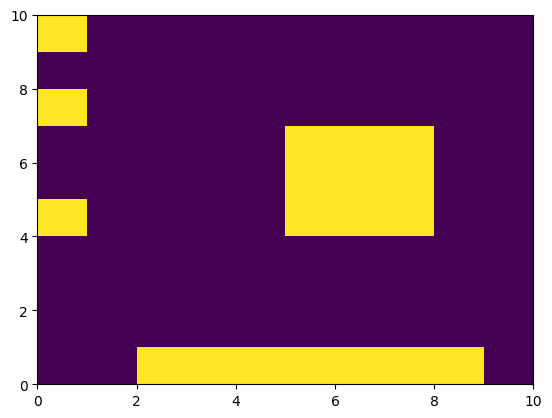

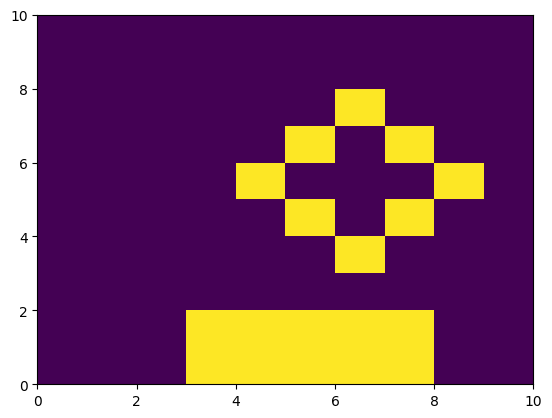

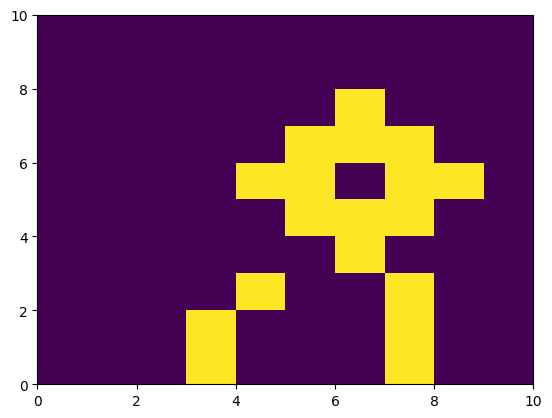

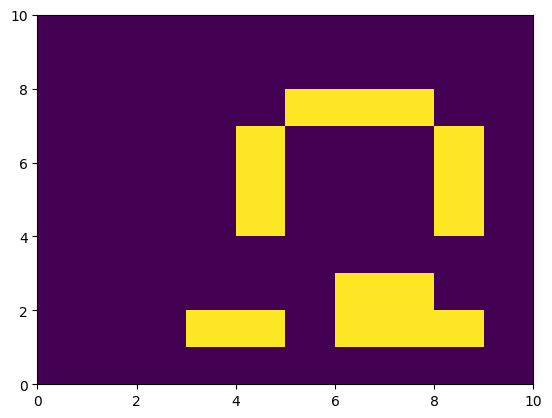

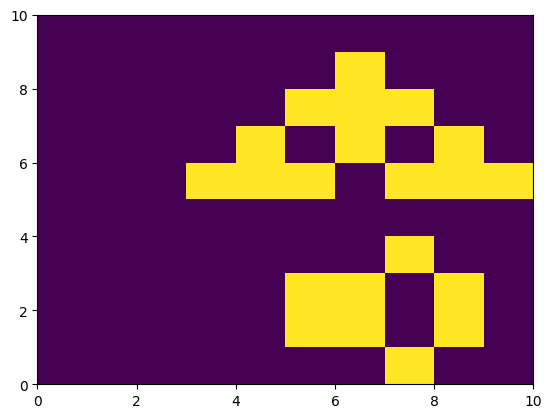

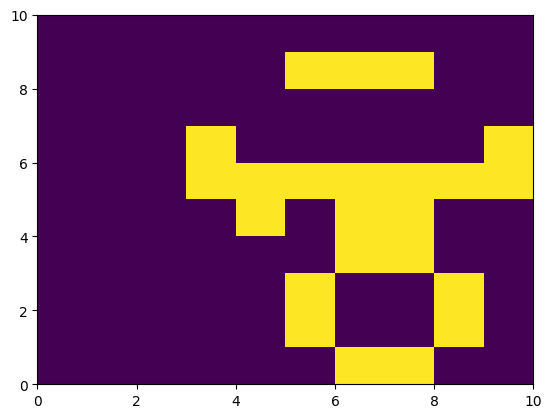

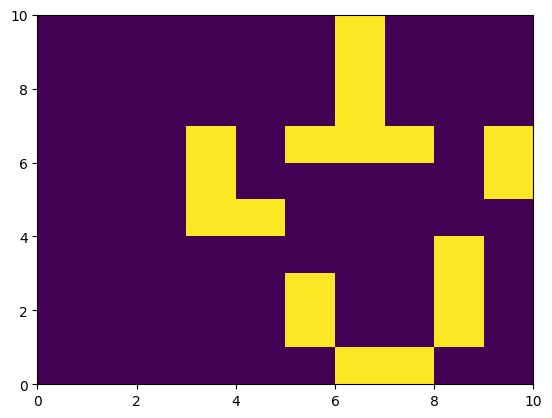

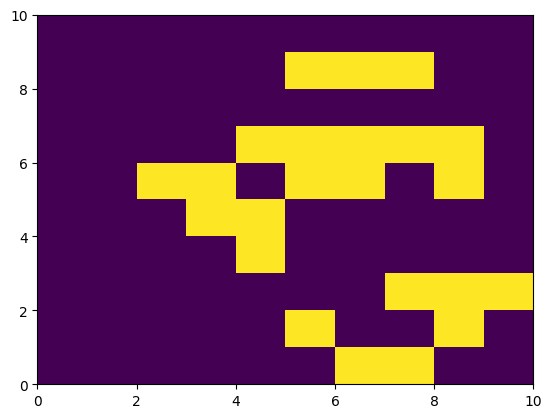

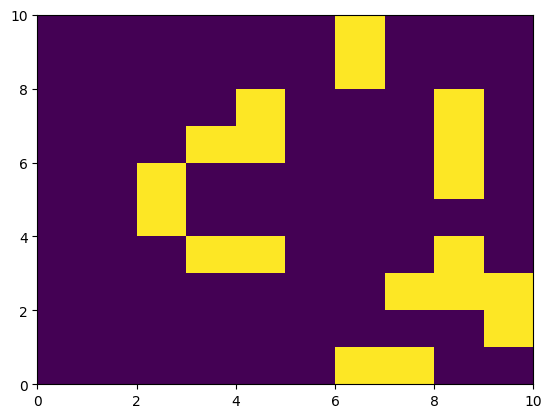

Ultima transição:


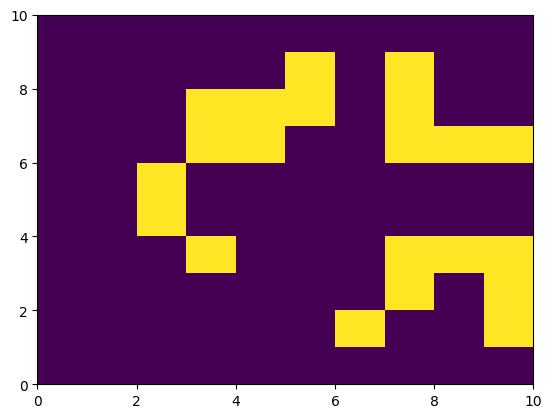

Todos os estados acessíveis contém pelo menos uma célula.
Não é possível resolver o B2 -> Existe pelo menos uma célula que se mantem morta em todas as transições


In [12]:
def euclides(declare, init, grid_N, t, print_all, x, y, sample_i, sample_j):
    with Solver(name="z3") as solver:
        #criação de todas as celulas em todos os estados
        states = [declare(grid_N, k) for k in range(t)]

        #atribuição das condições a transição inicial
        tr = init(states[0], x, y, sample_i, sample_j)
        
        formula = []
        formula.append(tr)
        for i in tr:
            solver.add_assertion(i)
            
        #calculo de todas as transiçoes
        for k in range(t-1):
            values = get_values(states[k], solver)
            if print_all or k == 0:
                print_state(values)
            curr = trans(values, states[k+1])
            formula.append(curr)
            for i in curr:
                solver.add_assertion(i)
        
        #print da ultima transiçao
        print("Ultima transição:")
        values = get_values(states[t-1], solver)
        print_state(values)
        
        #B1
        #em cada estado tem que pelo menos uma celula morta ou viva
        for t in states:
            cells = [j.Iff(TRUE()) for i in t for j in i] + [j.Iff(FALSE()) for i in t for j in i]
            solver.add_assertion(Or(*cells))
        if solver.solve():
            print("Todos os estados acessíveis contém pelo menos uma célula.")
        else:
            print("Não e possível resolver o B1 -> Existe pelo menos um estado sem uma célula")
            
        #como B1 é sempre verdadeira podemos provar B2 sem remover as assertions
        #B2
        #divisão de cada coordenada por estado
        dict = {}
        for t in states:
            for y in range(len(t)):
                for x in range(len(t[0])):
                    if f"({x},{y})" not in dict:
                        dict[f"({x},{y})"] = [t[y][x].Iff(TRUE())]
                    else:
                        dict[f"({x},{y})"] += [t[y][x].Iff(TRUE())]      
        #adição lógica em cada coordenada em todos os estado
        for v in dict.values():
            solver.add_assertion(Or(*v))
        if solver.solve():
            print("Todas a célula normal está viva pelo menos uma vez em algum estado acessível.")
        else:
            print("Não é possível resolver o B2 -> Existe pelo menos uma célula que se mantem morta em todas as transições")
            
euclides(declare, init, grid_N, days, print_all, x, y, sample_i, sample_j)